<a href="https://colab.research.google.com/github/eecoubrough/Keras_Assignment/blob/main/Part_1_multiclass.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning Medical Image Analysis Example
A simple convolutional neural network model trained using a simple pathology image dataset.

To use GPU acceleration make sure to change your runtime type in Google Colab to GPU.

## Python Imports
This section will load the necessary python packages to the instance.

In [1]:
# Built-in Imports
import random

In [2]:
# Library Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from tabulate import tabulate
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [3]:
# Keras Imports
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import get_file, to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## Dataset Downloader
This section will download the BloodMNIST dataset as a NumPy array object to the Google Colab instance. Note that the dataset does need to be redownloaded every time an instance is created.

In [4]:
# The dataset selected is BloodMNIST
# If desired, a different MedMNIST dataset could be used simply by specifying the desired dataset name.
DATA_NAME = "BloodMNIST"

In [5]:
# Retrieves the dataset from GitHub
!wget https://raw.githubusercontent.com/MedMNIST/MedMNIST/main/medmnist/info.py
from info import INFO
data = INFO[DATA_NAME.lower()]

--2024-04-01 16:41:37--  https://raw.githubusercontent.com/MedMNIST/MedMNIST/main/medmnist/info.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 27766 (27K) [text/plain]
Saving to: ‘info.py’

info.py             100%[===================>]  27.12K  --.-KB/s    in 0.002s  

2024-04-01 16:41:37 (16.7 MB/s) - ‘info.py’ saved [27766/27766]



In [6]:
# Downloads the dataset file hosted on Zenodo.
file_path = get_file(fname="dataset.npz",
                     origin=data["url"],
                     md5_hash=data["MD5"])

35461855/35461855 [==============================] - 3s 0us/step


In [7]:
# Loads the downloaded NumPy object, saving it to the variable 'dataset'.
dataset = np.load(file_path)

# Gets the training images and labels from the NumPy object.
train_x = dataset["train_images"]
train_y = dataset["train_labels"]

# Gets the validation images and labels from the NumPy object.
val_x = dataset["val_images"]
val_y = dataset["val_labels"]

# Gets the testing images and labels from the NumPy object.
test_x = dataset["test_images"]
test_y = dataset["test_labels"]

## Data Exploration
In this section we have a look at our data, their distributions to see if it is ready to be used within our machine learning algorithm.

In [8]:
# Print the shape of one of the images in your dataset to ensure the images are in the expected shape format.
print(train_x[0].shape)

(28, 28, 3)


In [9]:
# Declares a list of labels.
labels = list(data["label"].values()) + ["total"]

# Gets the counts for each label in each of our datasets.
_, train_counts = np.unique(train_y, return_counts=True)
_, val_counts = np.unique(val_y, return_counts=True)
_, test_counts = np.unique(test_y, return_counts=True)

# Prints the counts for each label from each dataset (used to check the distributions of data in each of the eight classes to ensure there is no unexpected discepencies).
print(pd.DataFrame(list(zip(np.append(train_counts, [sum(train_counts)]),
                            np.append(val_counts, [sum(val_counts)]),
                            np.append(test_counts, [sum(test_counts)]))),
                   index=labels, columns=["Train", "Val", "Test"]))

                                                    Train   Val  Test
basophil                                              852   122   244
eosinophil                                           2181   312   624
erythroblast                                         1085   155   311
immature granulocytes(myelocytes, metamyelocyte...   2026   290   579
lymphocyte                                            849   122   243
monocyte                                              993   143   284
neutrophil                                           2330   333   666
platelet                                             1643   235   470
total                                               11959  1712  3421


6440: erythroblast


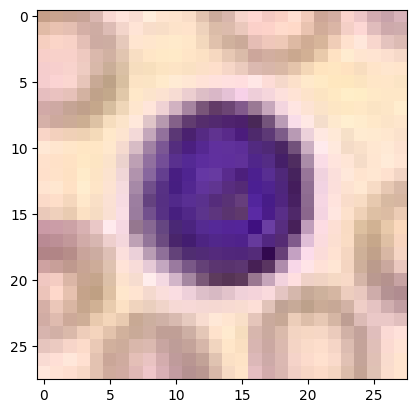

In [10]:
# Displays a random image from training dataset.
index = random.randint(0, len(train_x))
print(f"{index}: {labels[train_y[index][0]]}")
plt.imshow(train_x[random.randint(0, len(train_x))])

## Data Processing
In this section we will create a data loader for algorithm that will dynamically load and augment the data when needed.

In [11]:
# Defines the data generator that will be used to augment the images as they are loaded.
data_generator = ImageDataGenerator(featurewise_center=True,
                                    featurewise_std_normalization=True,
                                    horizontal_flip=True,
                                    vertical_flip=True)

In [12]:
data_generator.fit(np.append(train_x, val_x, 0))

---
# **Part 1 - Covnet with same architechture and training regime**

## Model Definition

**This section defines a convnet with the same architecture and training regime as in the example Colab notebook. The model has 2 convolutional layers with max pooling, a flattening layer, then an output layer.**

<br>

The convolutional layers use the ReLU (Rectified Linear Unit) activation function. This sets all negative values to zero and keeps all positive values unchanged. ReLU is the most common function used for hidden layers because it is simple to implement and, unlike the other activation function options, ReLU does not have a vanishing gradient problem.

<br>

The flatten layer reshapes the output of the preceding layers into a one-dimensional array. This step is necessary to prepare the data for the fully connected layers.

<br>

The output layer...

In [13]:
# Define the input layer of the model with the size of an image.
input = layers.Input(shape=train_x[0].shape)

# Defines the first convolutional layer with max pooling.
conv_1 = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(input)
pool_1 = layers.MaxPool2D(pool_size=(2, 2))(conv_1)

# Defines the second convolutional layer with max pooling.
conv_2 = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(pool_1)
pool_2 = layers.MaxPool2D(pool_size=(2, 2))(conv_2)

# Flattens the outputs of the convolutoonal layers into a one dimensional array.
flatten = layers.Flatten()(pool_2)

# Defines the output layer of the model a number of output nodes equal to the number of classes.
output = layers.Dense(units=8, activation="softmax")(flatten)

# Initilises the defined model and prints summary of the model.
model_1 = Model(inputs=input, outputs=output, name="Model_1")
model_1.summary()

Model: "Model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 26, 26, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 13, 13, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 5, 5, 32)          0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 800)               0   

## Model Training
This is where we define the training options and then train the model.


In [14]:
# Defines the parameters used during training.
BATCH_SIZE = 64
NUM_EPOCHS = 10
LEARNING_RATE = 0.001

In [15]:
# Defines the optimiser used to adjust the model weights and compiles the model.
optimiser = SGD(learning_rate=LEARNING_RATE)
model_1.compile(optimizer=optimiser, loss="categorical_crossentropy", metrics=["accuracy"])

In [16]:
# We use the data generator to pass the training and validation data to the model to train it.
history_1 = model_1.fit(data_generator.flow(train_x, to_categorical(train_y), batch_size=BATCH_SIZE),
                    steps_per_epoch=len(train_x) / BATCH_SIZE,
                    validation_data=data_generator.flow(val_x, to_categorical(val_y), batch_size=BATCH_SIZE),
                    validation_steps=len(val_x) / BATCH_SIZE,
                    epochs=NUM_EPOCHS)

Epoch 1/10
186/186 [==============================] - 10s 18ms/step - loss: 1.8879 - accuracy: 0.3151 - val_loss: 1.7835 - val_accuracy: 0.4457
Epoch 2/10
186/186 [==============================] - 2s 8ms/step - loss: 1.6925 - accuracy: 0.4924 - val_loss: 1.6027 - val_accuracy: 0.5263
Epoch 3/10
186/186 [==============================] - 2s 8ms/step - loss: 1.5189 - accuracy: 0.5480 - val_loss: 1.4299 - val_accuracy: 0.5678
Epoch 4/10
186/186 [==============================] - 2s 11ms/step - loss: 1.3572 - accuracy: 0.5862 - val_loss: 1.2729 - val_accuracy: 0.6162
Epoch 5/10
186/186 [==============================] - 2s 8ms/step - loss: 1.2237 - accuracy: 0.6317 - val_loss: 1.1599 - val_accuracy: 0.6478
Epoch 6/10
186/186 [==============================] - 2s 8ms/step - loss: 1.1193 - accuracy: 0.6572 - val_loss: 1.0723 - val_accuracy: 0.6682
Epoch 7/10
186/186 [==============================] - 2s 8ms/step - loss: 1.0360 - accuracy: 0.6780 - val_loss: 0.9938 - val_accuracy: 0.6928
Epo

## Plot Learning Curves
This is where we visualise the training of the model.

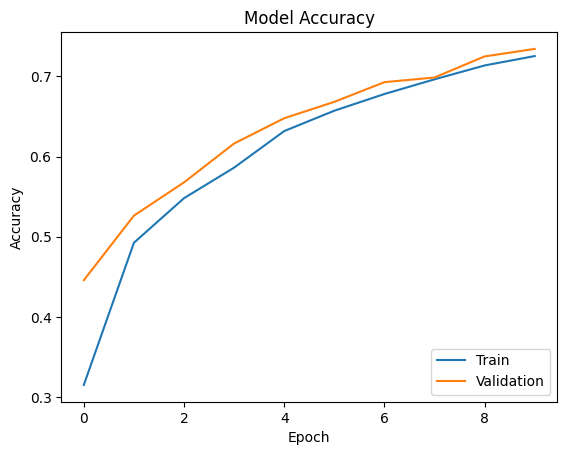

In [17]:
# Plots the training and validation accuracy over the number of epochs.
plt.plot(history_1.history['accuracy'])
plt.plot(history_1.history['val_accuracy'])

# Add plot title.
plt.title('Model Accuracy')

# Add plot axes labels.
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

# Add plot legend to distinguish between training and validation accuracy lines.
plt.legend(['Train', 'Validation'], loc='lower right')

# Show the plot.
plt.show()

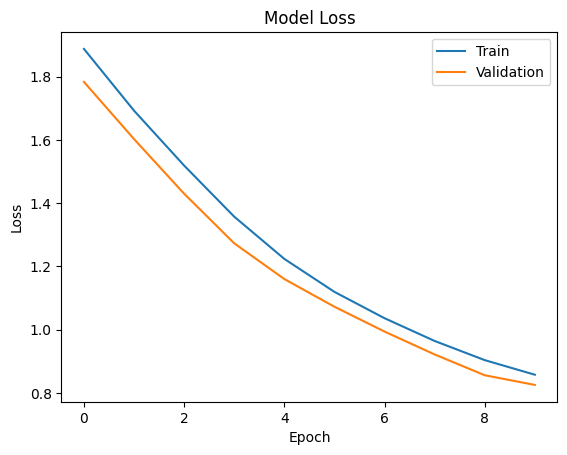

In [18]:
# Plots the training and validation loss over the number of epochs.
plt.plot(history_1.history['loss'])
plt.plot(history_1.history['val_loss'])

# Add plot title.
plt.title('Model Loss')

# Add plot axes labels.
plt.ylabel('Loss')
plt.xlabel('Epoch')

# Add plot legend to distinguish between training and validation accuracy lines.
plt.legend(['Train', 'Validation'], loc='upper right')

# Show the plot.
plt.show()



---
#**Part 2 - A network with only dense layers**


## Model Definition

**This section defines a network with dense layers but no convolutional layers, designed to have a total number of parameters comparable to the convnet in 1.**

<br>

The flatten layer reshapes the data from the input layer into a one-dimensional array. This step is necessary to prepare the data for the dense layers, which require a one-dimentional input.

<br>

The two dense layers are fully connected layers i.e. each neuron is connected to every neuron in the previous layer. These layers serves as feature extractors, enabling the model to learn complex patterns and relationships in the data.

<br>

//

<br>

This model has been designed to have a similar number of parameters to model_1. This was achieved by adjusting the number of units in each of the dense layers.

> Model_1 has a total of 16552 parameters, and model_2 has 16559 parameters.

In [19]:
# Define the input layer of the model with the size of an image.
input = layers.Input(shape=train_x[0].shape)

# Flattens the outputs of the input layer into a 1D array.
flatten = layers.Flatten()(input)

# Dense layer 1 with 7 units and ReLU activation.
dense_1 = layers.Dense(units=7, activation="relu")(flatten)

# Dense layer 2 with 5 units and ReLU activation.
dense_2 = layers.Dense(units=5, activation="relu")(dense_1)

# Defines the output layer of the model with the number of output nodes equal to the number of classes in the dataset,
# using the softmax activation function to generate probabilities for each class.
output = layers.Dense(units=8, activation="softmax")(dense_2)

# Initializes the defined model with the input and output layers.
model_2 = Model(inputs=input, outputs=output, name="Model_2")

# Print the summary of the model.
model_2.summary()

Model: "Model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 28, 28, 3)]       0         
                                                                 
 flatten_1 (Flatten)         (None, 2352)              0         
                                                                 
 dense_1 (Dense)             (None, 7)                 16471     
                                                                 
 dense_2 (Dense)             (None, 5)                 40        
                                                                 
 dense_3 (Dense)             (None, 8)                 48        
                                                                 
Total params: 16559 (64.68 KB)
Trainable params: 16559 (64.68 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Model Training
This is where we define the training options and then train the model.


In [20]:
# Defines the parameters used during training.
# Since the training regime is to be the same as for model_1, these parameters are the same as they were previously.
BATCH_SIZE = 64
NUM_EPOCHS = 10
LEARNING_RATE = 0.001

In [21]:
# Define the optimizer with the above specified learning rate.
optimiser = SGD(learning_rate=LEARNING_RATE)

# Compile the model with the above defined optimizer, categorical crossentropy loss, and accuracy metric.
model_2.compile(optimizer=optimiser, loss="categorical_crossentropy", metrics=["accuracy"])

In [22]:
# We use the data generator to pass the training and validation data to the model to train it.
history_2 = model_2.fit(data_generator.flow(train_x, to_categorical(train_y), batch_size=BATCH_SIZE),
                    steps_per_epoch=len(train_x) / BATCH_SIZE,
                    validation_data=data_generator.flow(val_x, to_categorical(val_y), batch_size=BATCH_SIZE),
                    validation_steps=len(val_x) / BATCH_SIZE,
                    epochs=NUM_EPOCHS)

Epoch 1/10
186/186 [==============================] - 2s 9ms/step - loss: 2.1042 - accuracy: 0.1066 - val_loss: 2.0761 - val_accuracy: 0.1028
Epoch 2/10
186/186 [==============================] - 2s 8ms/step - loss: 2.0658 - accuracy: 0.1194 - val_loss: 2.0535 - val_accuracy: 0.1209
Epoch 3/10
186/186 [==============================] - 1s 8ms/step - loss: 2.0440 - accuracy: 0.1493 - val_loss: 2.0371 - val_accuracy: 0.1507
Epoch 4/10
186/186 [==============================] - 2s 9ms/step - loss: 2.0255 - accuracy: 0.1806 - val_loss: 2.0177 - val_accuracy: 0.1957
Epoch 5/10
186/186 [==============================] - 2s 10ms/step - loss: 2.0088 - accuracy: 0.2182 - val_loss: 2.0051 - val_accuracy: 0.2366
Epoch 6/10
186/186 [==============================] - 1s 8ms/step - loss: 1.9877 - accuracy: 0.2482 - val_loss: 1.9834 - val_accuracy: 0.2535
Epoch 7/10
186/186 [==============================] - 2s 9ms/step - loss: 1.9746 - accuracy: 0.2617 - val_loss: 1.9659 - val_accuracy: 0.2605
Epoch

## Plot Learning Curves
This is where we visualise the training of the model.

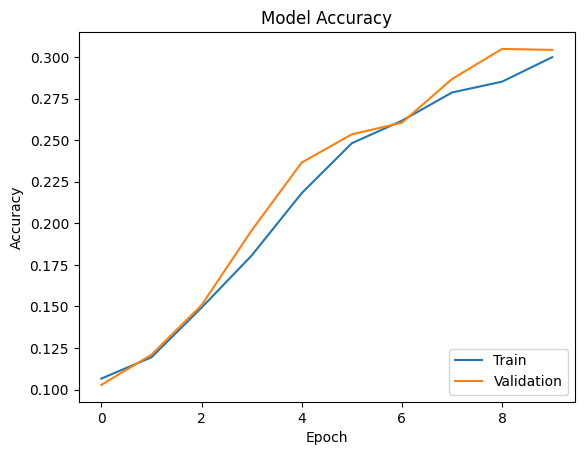

In [23]:
# Plots the training and validation accuracy over the number of epochs.
plt.plot(history_2.history['accuracy'])
plt.plot(history_2.history['val_accuracy'])

# Add plot title.
plt.title('Model Accuracy')

# Add plot axes labels.
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

# Add plot legend to distinguish between training and validation accuracy lines.
plt.legend(['Train', 'Validation'], loc='lower right')

# Show the plot.
plt.show()

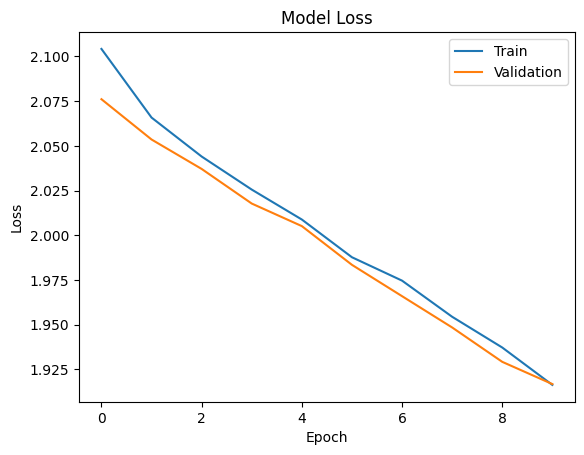

In [24]:
# Plots the training and validation loss over the number of epochs.
plt.plot(history_2.history['loss'])
plt.plot(history_2.history['val_loss'])

# Add plot title.
plt.title('Model Loss')

# Add plot axes labels.
plt.ylabel('Loss')
plt.xlabel('Epoch')

# Add plot legend to distinguish between training and validation accuracy lines.
plt.legend(['Train', 'Validation'], loc='upper right')

# Show the plot.
plt.show()


---
#**Part 3 - A deep network of my own design**

## Data Augmentation

Data augmentation is a technique used to artificially increase the diversity and size of a dataset by applying various transformations to the existing data samples.

<br>

 Data augmentation increases the performance of a model through improving generalisation, model robustness and adaptability.

 I have made use of a number of transformations for this model, as shown below.


In [25]:
# Defines the data generator for augmenting images during loading.
data_generator = ImageDataGenerator(featurewise_center=True,  # Centers the pixel values of each image around zero.
                                    featurewise_std_normalization=True,     # Standardizes the pixel values of each image.
                                    horizontal_flip=True,     # Randomly flips images horizontally.
                                    vertical_flip=True,     # Randomly flips images vertically.
                                    )

In [26]:
data_generator.fit(np.append(train_x, val_x, 0))

## Model Definition
In this section we will define the neural network arcitecture.

In [27]:
# Define the input layer of the model with the size of an image.
input = layers.Input(shape=train_x[0].shape)

# Defines the convolutional layer with max pooling.
conv_1 = layers.Conv2D(filters=32, kernel_size=3, activation="relu", kernel_regularizer=regularizers.l2(0.0001))(input)
pool_1 = layers.MaxPool2D(pool_size=(2, 2))(conv_1)

# Flattens the outputs of the convolutional layers into a one-dimensional array.
flatten = layers.Flatten()(pool_1)

# Dense layer with ReLU activation
dense = layers.Dense(units=16, activation="relu")(flatten)

# Defines the output layer of the model with a number of output nodes equal to the number of classes (8 classes for BloodMNIST),
# using the softmax activation function to generate probabilities for each class.
output = layers.Dense(units=8, activation="softmax", kernel_regularizer=regularizers.l2(0.0001))(dense)

# Initializes the defined model.
model_3 = Model(inputs=input, outputs=output, name="Model_3")

# Print the model summary.
model_3.summary()

Model: "Model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 28, 28, 3)]       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 26, 26, 32)        896       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 13, 13, 32)        0         
 g2D)                                                            
                                                                 
 flatten_2 (Flatten)         (None, 5408)              0         
                                                                 
 dense_4 (Dense)             (None, 16)                86544     
                                                                 
 dense_5 (Dense)             (None, 8)                 136       
                                                           

## Model Training
This is where we define the training options and then train the model.

Through testing different values for the training parameters, I determined that a smaller batch size, more epochs, and a lower learning rate was optimum.


In [30]:
# Defining the parameters used during training.
BATCH_SIZE = 32 #Batch size should always be a power of 2 GPU allocation purposes (quicker as no additional calculations required by the computer)
NUM_EPOCHS = 20
LEARNING_RATE = 0.001

In [31]:
# Define the optimizer with the above specified learning rate.
optimiser = SGD(learning_rate=LEARNING_RATE)

# Compile the model with the above defined optimizer, categorical crossentropy loss, and accuracy metric.
model_3.compile(optimizer=optimiser, loss="categorical_crossentropy", metrics=["accuracy", "categorical_accuracy"])

In [32]:
# Train the model using training data generated in batches by the data generator.
history_3 = model_3.fit(
    # Training data generator that yields augmented batches of images and their corresponding one-hot encoded labels.
    data_generator.flow(train_x, to_categorical(train_y), batch_size=BATCH_SIZE),
    # Number of steps (batches) per epoch is calculated as the total number of training samples divided by the batch size.
    steps_per_epoch=len(train_x) / BATCH_SIZE,
    # Validation data generator that yields batches of validation images and their corresponding one-hot encoded labels.
    validation_data=data_generator.flow(val_x, to_categorical(val_y), batch_size=BATCH_SIZE),
    # Number of steps (batches) per validation epoch is calculated as the total number of validation samples divided by the batch size.
    validation_steps=len(val_x) / BATCH_SIZE,
    # Number of epochs to train the model.
    epochs=NUM_EPOCHS
)

Epoch 1/20
373/373 [==============================] - 4s 7ms/step - loss: 1.6121 - accuracy: 0.4477 - categorical_accuracy: 0.4477 - val_loss: 1.3125 - val_accuracy: 0.5625 - val_categorical_accuracy: 0.5625
Epoch 2/20
373/373 [==============================] - 2s 6ms/step - loss: 1.1591 - accuracy: 0.6102 - categorical_accuracy: 0.6102 - val_loss: 1.0231 - val_accuracy: 0.6501 - val_categorical_accuracy: 0.6501
Epoch 3/20
373/373 [==============================] - 3s 8ms/step - loss: 0.9620 - accuracy: 0.6788 - categorical_accuracy: 0.6788 - val_loss: 0.8980 - val_accuracy: 0.7050 - val_categorical_accuracy: 0.7050
Epoch 4/20
373/373 [==============================] - 2s 6ms/step - loss: 0.8495 - accuracy: 0.7167 - categorical_accuracy: 0.7167 - val_loss: 0.7906 - val_accuracy: 0.7506 - val_categorical_accuracy: 0.7506
Epoch 5/20
373/373 [==============================] - 3s 9ms/step - loss: 0.7715 - accuracy: 0.7481 - categorical_accuracy: 0.7481 - val_loss: 0.7177 - val_accuracy: 0.

# Comparing the models

In [35]:
# Retrieve the maximum validation accuracy for each model
max_accs = [max(history_1.history['val_accuracy']), max(history_2.history['val_accuracy']), max(history_3.history['val_accuracy'])]

# Retrieve the minimum validation loss for each model
min_losses = [min(history_1.history['val_loss']), min(history_2.history['val_loss']), min(history_3.history['val_loss'])]

# Table data
data = [["Model 1", max_accs[0], min_losses[0]],
        ["Model 2", max_accs[1], min_losses[1]],
        ["Model 3", max_accs[2], min_losses[2]]]

# Display table
print(tabulate(data, headers=["Model", "Max Validation Accuracy", "Min Validation Loss"], tablefmt="fancy_grid"))

╒═════════╤═══════════════════════════╤═══════════════════════╕
│ Model   │   Max Validation Accuracy │   Min Validation Loss │
╞═════════╪═══════════════════════════╪═══════════════════════╡
│ Model 1 │                  0.734229 │              0.825076 │
├─────────┼───────────────────────────┼───────────────────────┤
│ Model 2 │                  0.304907 │              1.91673  │
├─────────┼───────────────────────────┼───────────────────────┤
│ Model 3 │                  0.858061 │              0.429501 │
╘═════════╧═══════════════════════════╧═══════════════════════╛


### Visualising the accuracy and loss for all 3 models within the same plot:

In [36]:
# Create colour palette by getting three colors from the Inferno colormap
colours = [cm.inferno(0.2), cm.inferno(0.5), cm.inferno(0.8)]

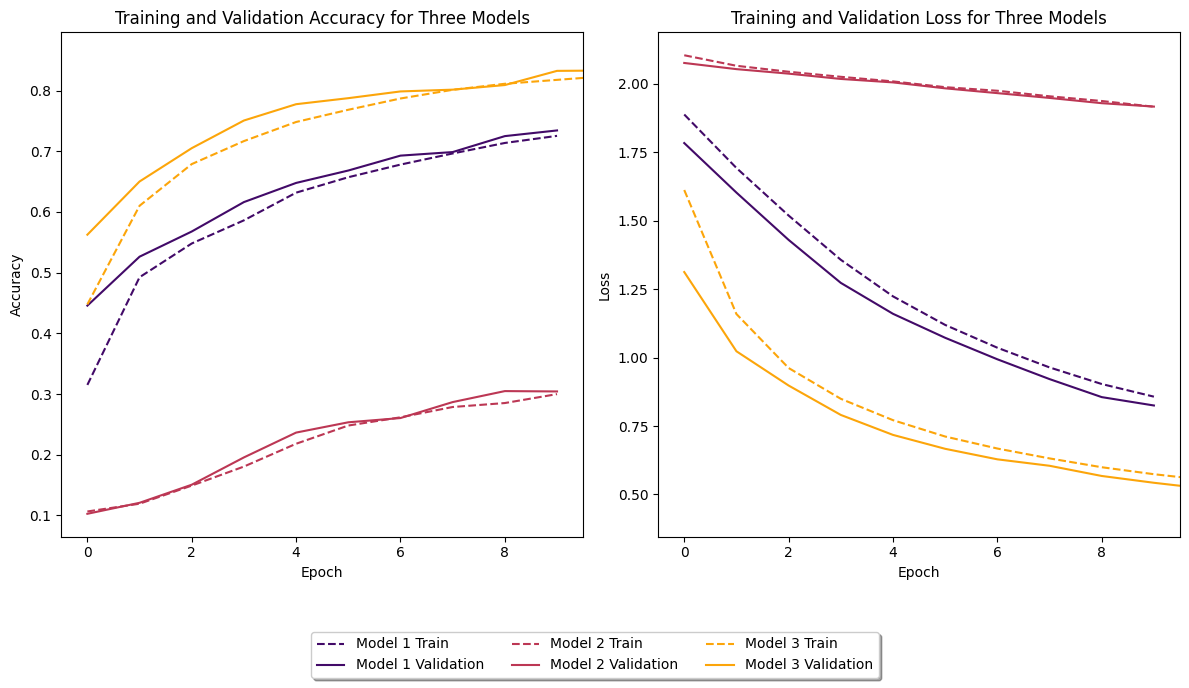

In [37]:
# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot training and validation accuracy for the three models
for i, history in enumerate([history_1, history_2, history_3]):
    axs[0].plot(history.history['accuracy'], label=f'Model {i+1} Train', linestyle='dashed', color=colours[i])
    axs[0].plot(history.history['val_accuracy'], label=f'Model {i+1} Validation', color=colours[i])

# Add plot title and axis labels for the accuracy subplot
axs[0].set_title('Training and Validation Accuracy for Three Models')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy')
axs[0].set_xlim(-0.5, 9.5) # Set x-axis limit to show the first 10 epochs

# Plot training and validation loss for the three models
for i, history in enumerate([history_1, history_2, history_3]):
    axs[1].plot(history.history['loss'], label=f'Model {i+1} Train', linestyle='dashed', color=colours[i])
    axs[1].plot(history.history['val_loss'], label=f'Model {i+1} Validation', color=colours[i])

# Add plot title and axis labels for the loss subplot
axs[1].set_title('Training and Validation Loss for Three Models')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].set_xlim(-0.5, 9.5) # Set x-axis limit to show the first 10 epochs

# Create a shared legend, below the subplots
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, -0.05), shadow=True, ncol=3)

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

The above table and plots contrast the accuracy and loss of each model, enabling easy comparison of the performance of each model.

<br>

Model 3 has the highest accuracy rates, followed by model 2, and model 1 is the least accurate.

<br>

Unlike the accuracy rates, it is much less clear-cut which model performs the best. Model 1 has the highest overall loss, but models 2 and 3 are very similar.

<br>

The loss of model 2 gradually and consistently decreased from the first epoch to the last. Whereas, model 3 has a much higher loss at the first two epochs, but it decreases to around the same as model 2 but the validation loss of model 3 does fluctuate. This could be due to several factors such as overfitting or nonoptimal hyperparameters.

<br>

I did attempt to optimise model 3 to minimise the fluctuation of the validation accuracy and loss. I adjusted factors such as the learning rate, regularisation parameters, data augmentation etc., but I was not able to improve the performance while still having a model which does not take days to train.

<br>

Because the training dataset is small (approx 4700), overfitting will always be a concern, especially for model 3 because it is more complex and it has nearly eight times more parameters than models 1 and 2. This is partially mitigated through the use of L2 regularisation, but the fluctuations in validation accuracy and loss indicates that there may still be a degree of overfitting.